<a href="https://colab.research.google.com/github/SainRigo/Yolov9_prunning/blob/main/notebooks/train-yolov9-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

<br>

![YOLOv9 Benchmark](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov9-benchmark.jpeg)

**Figure 1.**  Comparisons of the real-time object detecors on MS
COCO dataset. The GELAN and PGI-based object detection
method surpassed all previous train-from-scratch methods in terms
of object detection performance. Source: "YOLOv9: Learning What You Want to Learn Using Programmable Gradient Information"

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Mar  3 11:23:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 147, done.
remote: Total 147 (delta 0), reused 0 (delta 0), pack-reused 147
Receiving objects: 100% (147/147), 607.53 KiB | 21.70 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


**NOTE:** Let's install additional packages that will be useful later on.

In [4]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00


## Imports

In [5]:
import roboflow

from IPython.display import Image

## Download model weights

**NOTE:** In the YOLOv9 paper, versions yolov9-s and yolov9-m are also mentioned, but the weights for these models are not yet available in the YOLOv9 repository.

In [6]:
!mkdir -p {HOME}/weights

In [7]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [8]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 Mar  3 11:23 .
drwxr-xr-x 1 root root      4096 Mar  3 11:23 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


## Download example data

In [9]:
!mkdir -p {HOME}/data

In [10]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [11]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"

**NOTE:** If you want to run inference using your own file as input, simply upload image to Google Colab and update `SOURCE_IMAGE_PATH` with the path leading to your file.

## Detection with pre-trained COCO model

### gelan-c

In [12]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 467 layers, 25472640 parameters, 0 gradients, 102.8 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 handbag, 153.5ms
Speed: 0.4ms pre-process, 153.5ms inference, 683.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

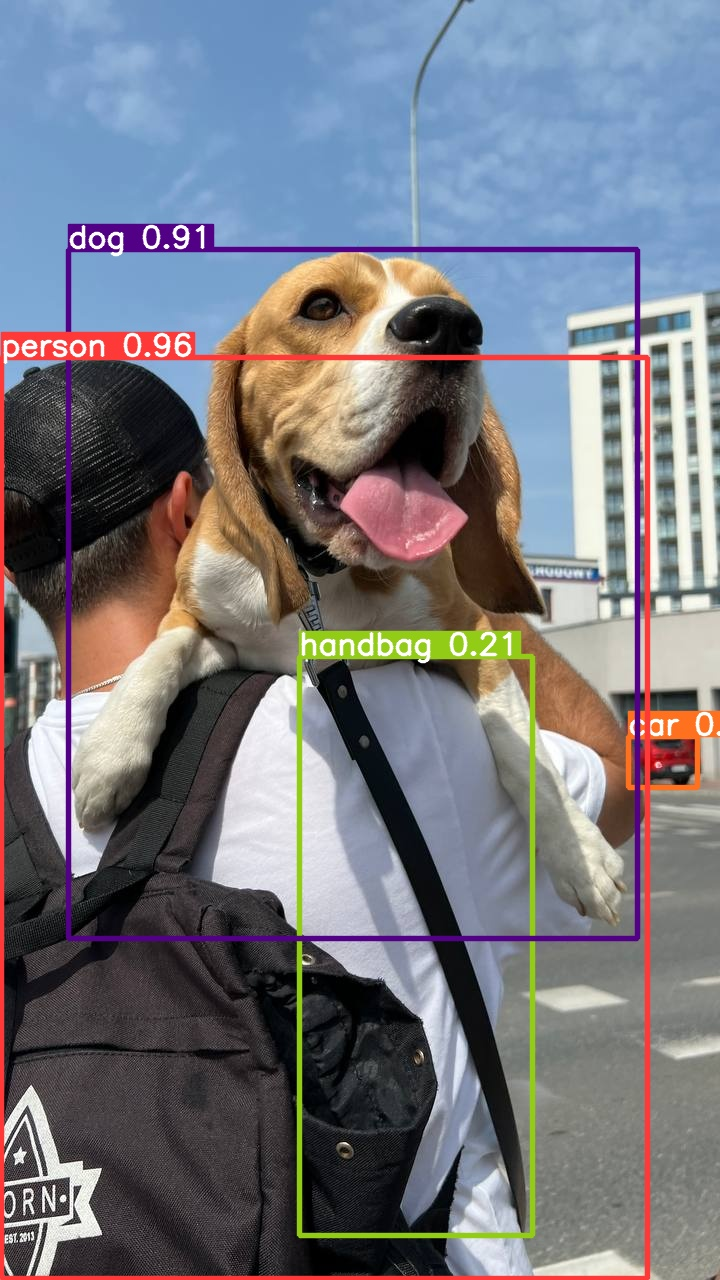

In [13]:
Image(filename=f"{HOME}/yolov9/runs/detect/exp/dog.jpeg", width=600)

## yolov9-e

In [14]:
!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 1119 layers, 69470144 parameters, 0 gradients, 244.0 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 1 handbag, 168.3ms
Speed: 0.4ms pre-process, 168.3ms inference, 521.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


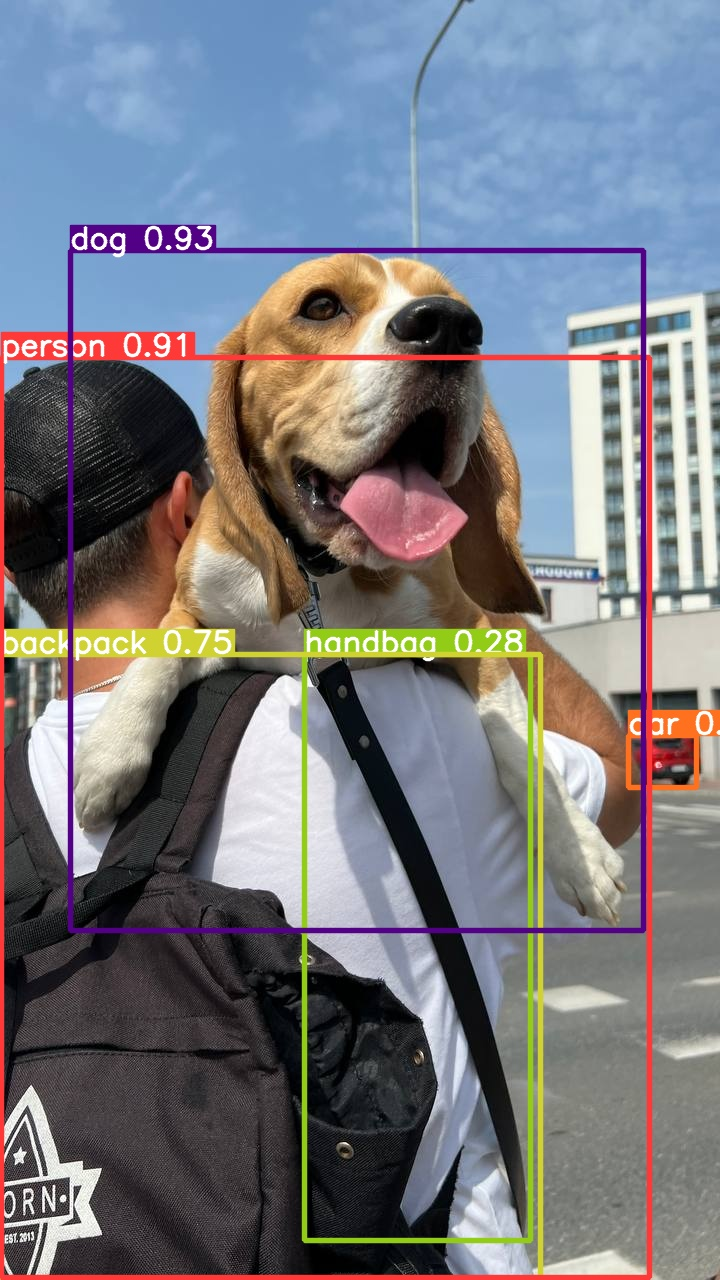

In [15]:
Image(filename=f"{HOME}/yolov9/runs/detect/exp2/dog.jpeg", width=600)

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [16]:
%cd {HOME}/yolov9

roboflow.login()

rf = roboflow.Roboflow()


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qn4WqRUZpaGHNMlJ3cuJ")
project = rf.workspace("plums-hhqfx").project("plums-0ucd7")
dataset = project.version(5).download("yolov9")

/content/yolov9
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plums-5 in yolov9:: 100%|██████████| 6000/6000 [00:01<00:00, 5235.80it/s]


## Train Custom Model

In [17]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 30 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-03-03 11:37:11.554128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 11:37:11.554175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 11:37:11.555530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 11:37:13.251478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=/content/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/content/yolov9/plums-5/data.yaml, hyp=hyp.scratch-high.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [18]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1709465835.985b067fea0a.4676.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


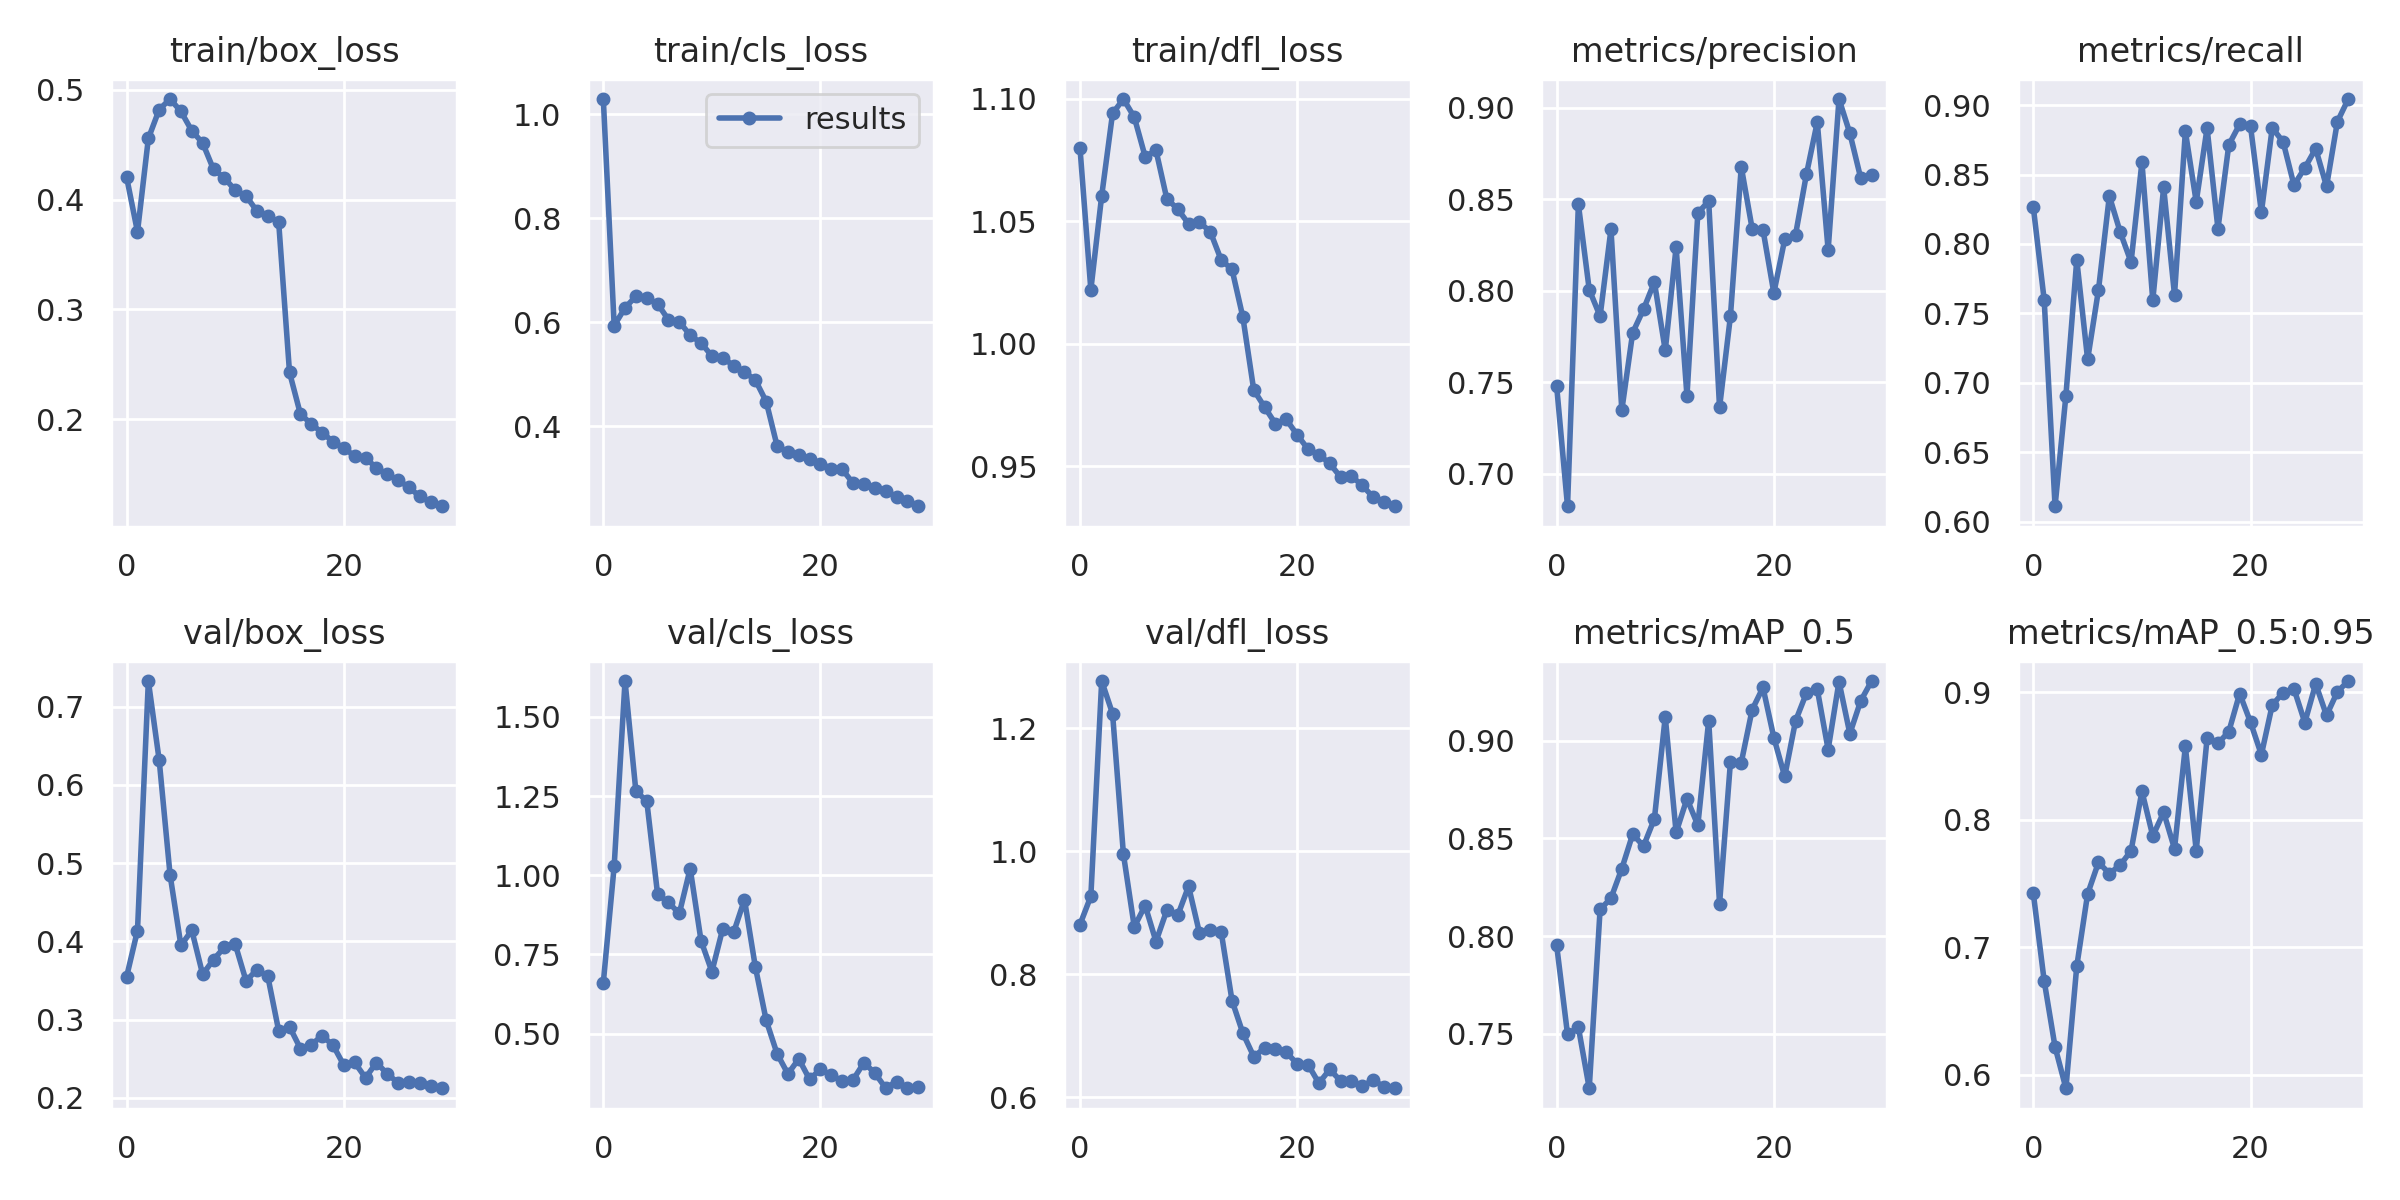

In [19]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

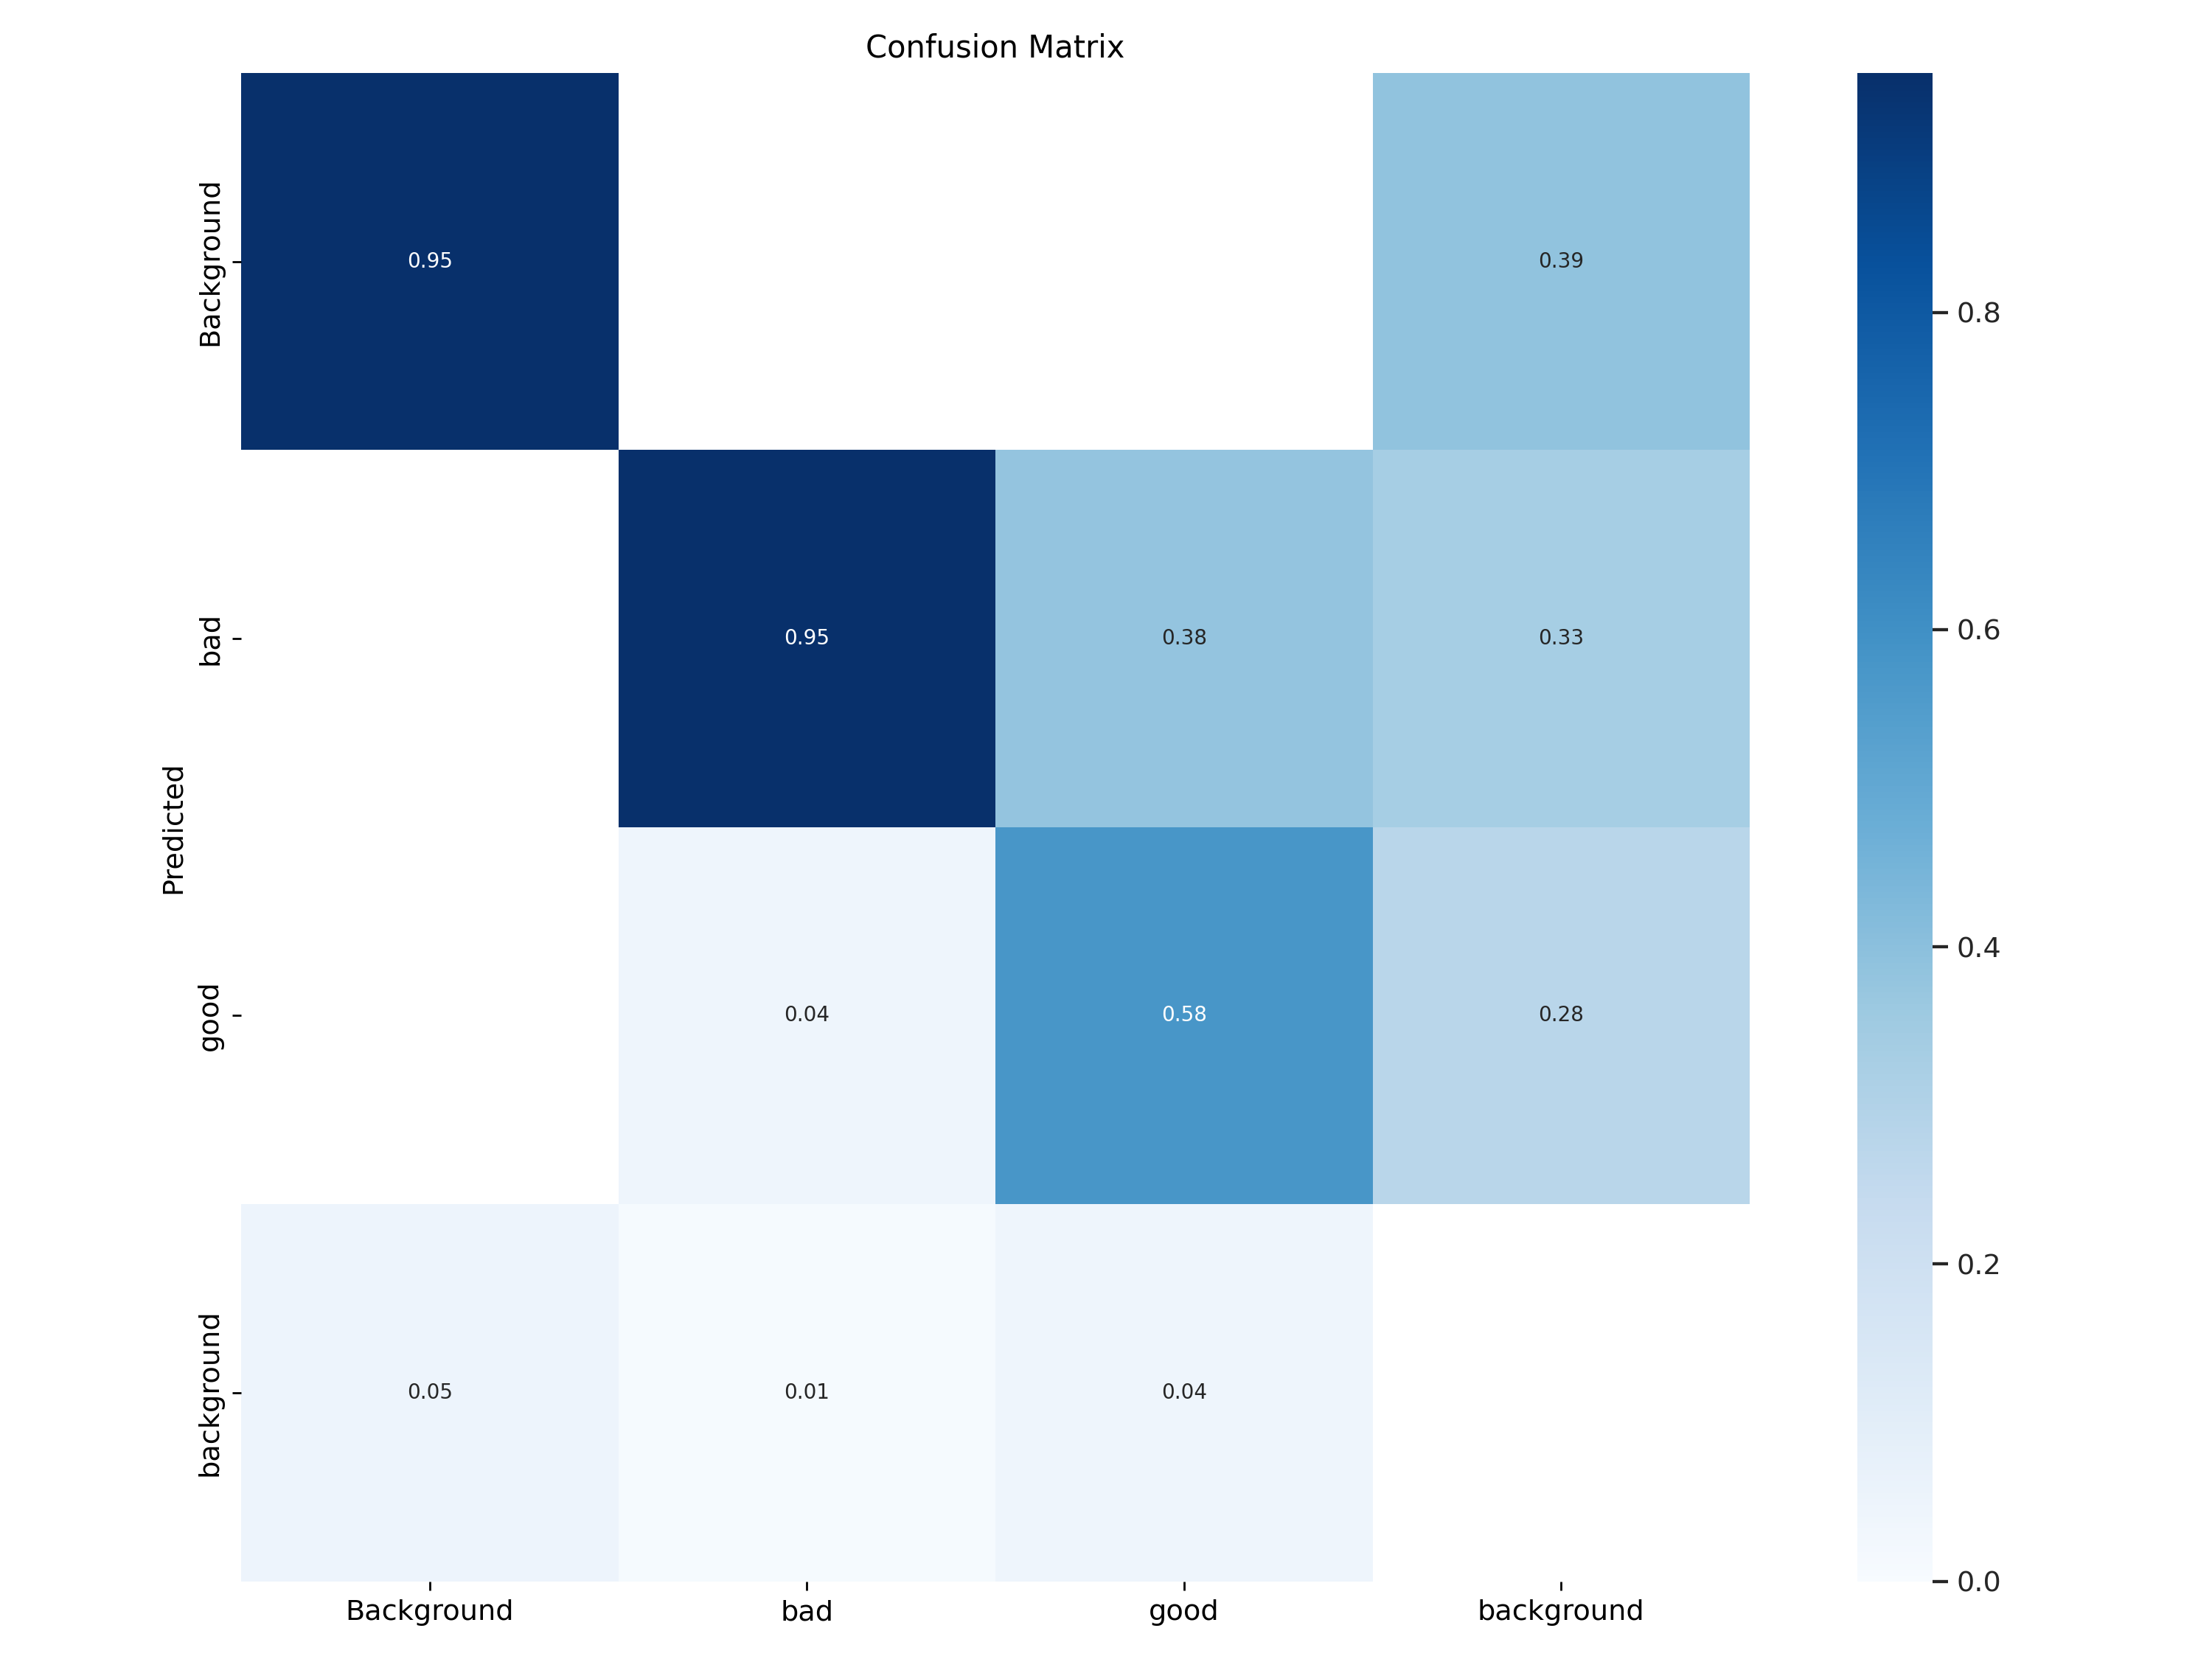

In [20]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

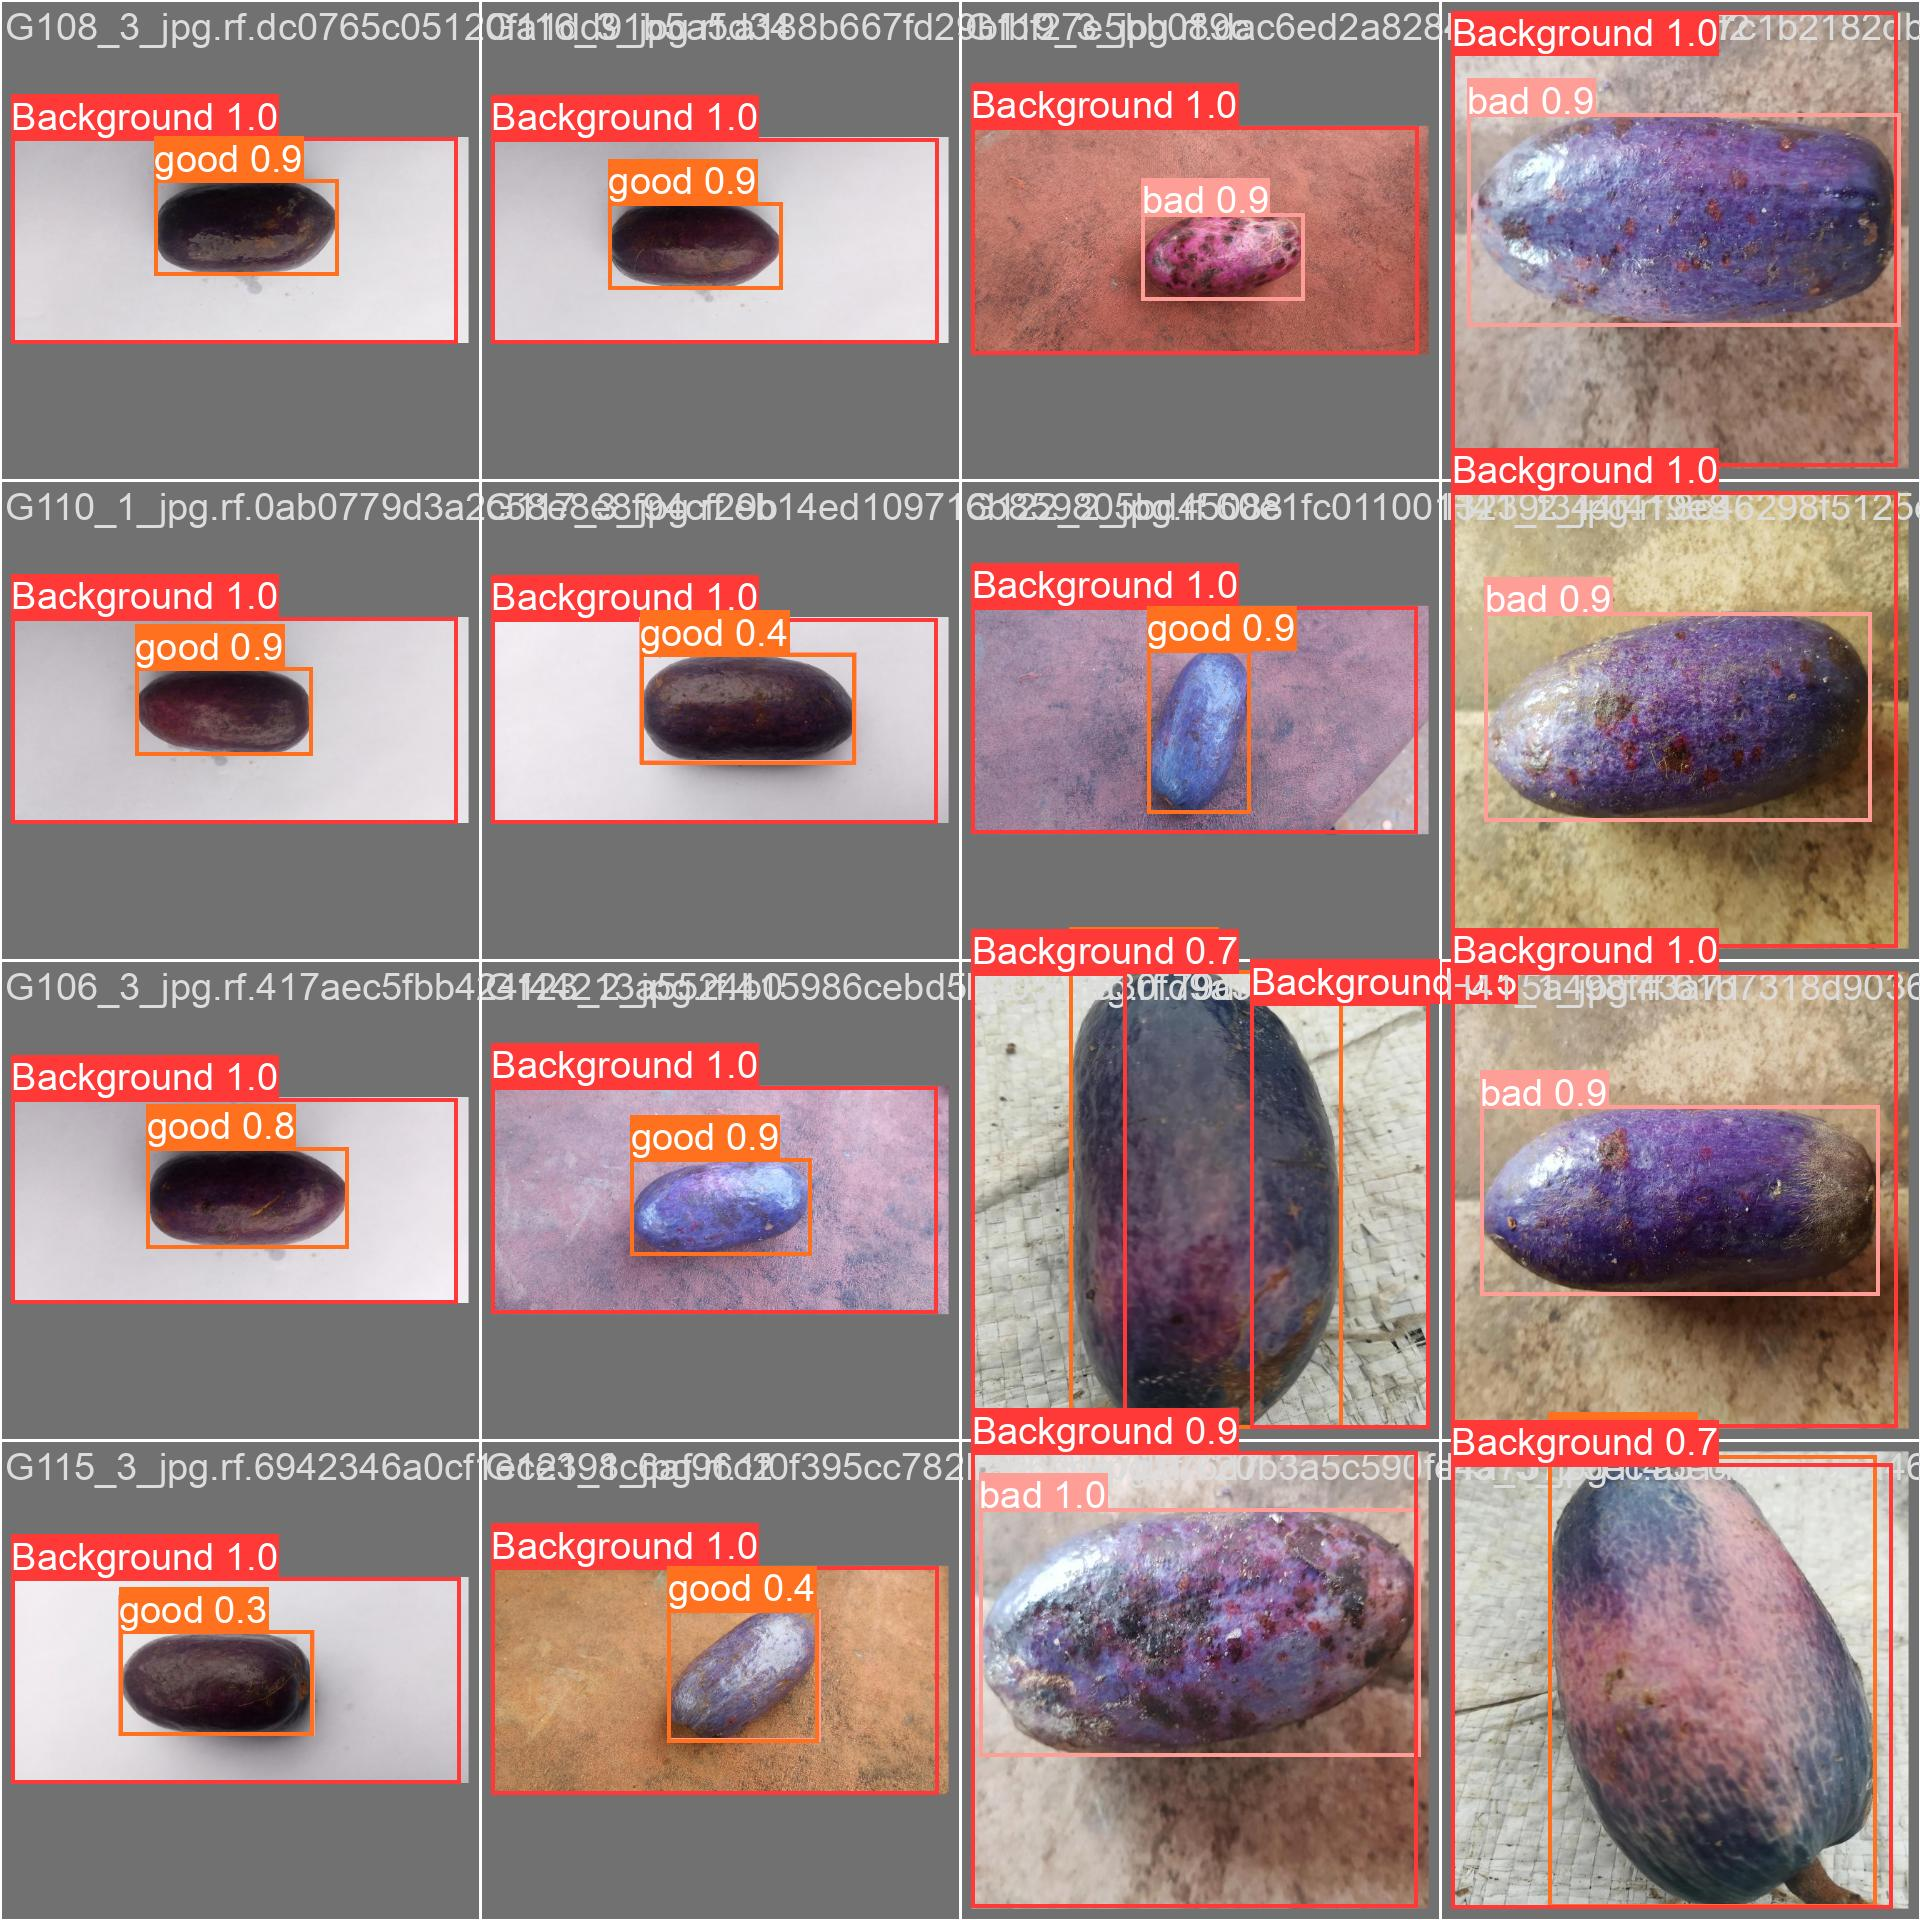

In [21]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [22]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/plums-5/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25413273 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/plums-5/valid/labels.cache... 453 images, 0 backgrounds, 0 corrupt: 100% 453/453 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 15/15 [00:28<00:00,  1.90s/it]
                   all        453        942      0.864      0.904      0.931      0.909
            Background        453        484       0.95       0.

In [23]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.3/716.3 kB 8.9 MB/s eta 0:00:00


In [54]:
import os

# Specify the path to your YOLOv5 model file
yolov9_model_path = "/content/yolov9/runs/train/exp/weights/best.pt"

# Check the size of the YOLOv5 model file
yolov9_model_size = os.path.getsize(yolov9_model_path)

# Convert the size to megabytes
yolov9_model_size_mb = yolov9_model_size / (1024 * 1024)

# Print the YOLOv5 model size in megabytes
print("YOLOv5 Model Size: {:.2f} MB".format(yolov9_model_size_mb))

YOLOv5 Model Size: 195.14 MB


In [55]:
import torch, torch.nn as nn
from torch.nn.utils import prune
from ultralytics import YOLO

model = YOLO("/content/yolov9/runs/train/exp/weights/best.pt")


def sparsity(model):
    # Return global model sparsity
    a, b = 0, 0
    for p in model.parameters():
        a += p.numel()
        b += (p == 0).sum()
    return b / a

pruning_param = 0.3

for name, m in model.model.named_modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, torch.nn.Linear):
        prune.l1_unstructured(m, name='weight', amount=pruning_param)  # prune
        prune.remove(m, 'weight')  # make permanent
print(f'Model pruned to {sparsity(model.model):.3g} global sparsity')

ckpt = {

            'model': model.model,
            'train_args': {},  # save as dict
}

torch.save(ckpt, '../model_pruned_3.pt')



Model pruned to 0.299 global sparsity


In [56]:
model = YOLO("../model_pruned_3.pt")

In [32]:
pip install models

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [57]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights /content/model_pruned_3.pt

/content/yolov9
val: data=/content/yolov9/plums-5/data.yaml, weights=['/content/model_pruned_3.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25413273 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/plums-5/valid/labels.cache... 453 images, 0 backgrounds, 0 corrupt: 100% 453/453 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 15/15 [00:24<00:00,  1.60s/it]
                   all        453        942       0.64      0.738      0.719      0.608
            Background        453        484      0.925      0.863      0.924      0

In [58]:
import os

# Specify the path to your YOLOv5 model file
yolov9_pruned_model_path = "/content/model_pruned_3.pt"

# Check the size of the YOLOv5 model file
yolov9_pruned_model_size = os.path.getsize(yolov9_pruned_model_path)

# Convert the size to megabytes
yolov9_pruned_model_mb = yolov9_pruned_model_size / (1024 * 1024)

# Print the YOLOv5 model size in megabytes
print("YOLOv9 pruned Model Size: {:.2f} MB".format(yolov9_pruned_model_mb))

YOLOv9 pruned Model Size: 97.70 MB


In [59]:
import torch, torch.nn as nn
from torch.nn.utils import prune
from ultralytics import YOLO

model = YOLO("/content/yolov9/runs/train/exp/weights/best.pt")


def sparsity(model):
    # Return global model sparsity
    a, b = 0, 0
    for p in model.parameters():
        a += p.numel()
        b += (p == 0).sum()
    return b / a

pruning_param = 0.2

for name, m in model.model.named_modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, torch.nn.Linear):
        prune.l1_unstructured(m, name='weight', amount=pruning_param)  # prune
        prune.remove(m, 'weight')  # make permanent
print(f'Model pruned to {sparsity(model.model):.3g} global sparsity')

ckpt = {

            'model': model.model,
            'train_args': {},  # save as dict
}

torch.save(ckpt, '../model_pruned_2.pt')

model = YOLO("../model_pruned_2.pt")

Model pruned to 0.2 global sparsity


In [60]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights /content/model_pruned_2.pt

/content/yolov9
val: data=/content/yolov9/plums-5/data.yaml, weights=['/content/model_pruned_2.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25413273 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/plums-5/valid/labels.cache... 453 images, 0 backgrounds, 0 corrupt: 100% 453/453 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 15/15 [00:23<00:00,  1.60s/it]
                   all        453        942      0.851       0.89      0.924      0.884
            Background        453        484      0.944      0.936      0.981      0

In [82]:
import os

# Specify the path to your YOLOv5 model file
yolov9__model_path = "/content/model_pruned_2.pt"

# Check the size of the YOLOv5 model file
yolov9__model_size = os.path.getsize(yolov9__model_path)

# Convert the size to megabytes
yolov9__model_size_mb = yolov9__model_size / (1024 * 1024)

# Print the YOLOv5 model size in megabytes
print("YOLOv5 Model Size: {:.2f} MB".format(yolov9_model_size_mb))

YOLOv5 Model Size: 195.14 MB


In [70]:
import torch, torch.nn as nn
from torch.nn.utils import prune
from ultralytics import YOLO

model = YOLO("/content/yolov9/runs/train/exp/weights/best.pt")


def sparsity(model):
    # Return global model sparsity
    a, b = 0, 0
    for p in model.parameters():
        a += p.numel()
        b += (p == 0).sum()
    return b / a

pruning_param = 0.1

for name, m in model.model.named_modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, torch.nn.Linear):
        prune.l1_unstructured(m, name='weight', amount=pruning_param)  # prune
        prune.remove(m, 'weight')  # make permanent
print(f'Model pruned to {sparsity(model.model):.3g} global sparsity')

ckpt = {

            'model': model.model,
            'train_args': {},  # save as dict
}

torch.save(ckpt, '../model_pruned_1_.pt')

model = YOLO("../model_pruned_1_.pt")

Model pruned to 0.0998 global sparsity


In [71]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights /content/model_pruned_1_.pt

/content/yolov9
val: data=/content/yolov9/plums-5/data.yaml, weights=['/content/model_pruned_1_.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25413273 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/plums-5/valid/labels.cache... 453 images, 0 backgrounds, 0 corrupt: 100% 453/453 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 15/15 [00:23<00:00,  1.56s/it]
                   all        453        942      0.858      0.909       0.93      0.907
            Background        453        484      0.946      0.955      0.985      

In [72]:


import os

# Specify the path to your YOLOv5 model file
yolov9___model__path = "/content/model_pruned_1_.pt"

# Check the size of the YOLOv5 model file
yolov9___model__size = os.path.getsize(yolov9___model__path)

# Convert the size to megabytes
yolov9___model__size_mb = yolov9___model__size / (1024 * 1024)

# Print the YOLOv5 model size in megabytes
print("YOLOv9 Model Size: {:.2f} MB".format(yolov9___model__size_mb))

YOLOv9 Model Size: 97.70 MB


In [73]:
yolov9___model__size = os.path.getsize("/content/model_pruned_1_.pt")

In [75]:
yolov9___model__size

102444326

## Inference with Custom Model

In [52]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/valid/images

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/yolov9/plums-5/valid/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25413273 parameters, 0 gradients, 102.5 GFLOPs
image 1/453 /content/yolov9/plums-5/valid/images/B2_3_jpg.rf.3417b499a23ebe507f03d15253345519.jpg: 1280x1280 2 Backgrounds, 1 bad, 120.6ms
image 2/453 /content/yolov9/plums-5/valid/images/B3_3_jpg.rf.82a52d7dacd7dfd75a572b45e6458684.jpg: 1280x1280 2 Backgrounds, 2 bads, 102.0ms
image 3/453 /content/yolov9/plums-5/va

In [81]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp3/*.jpg')[:0]:
      display(Image(filename=image_path, width=600))
      print("\n")